In [1]:
from locallib import *
print(w3.isConnected())

current block 31331243
True


In [269]:
datatstamp = '0218'
def load_data(protocol,asset_name):
    if protocol == "beefy":
        assets = None
        debt = None
        # supply = np.load('data%s/%s_%s_supply.npy'%(
        #     datatstamp,protocol,asset_name),allow_pickle=True)
        tvl = np.load('data%s/%s_%s_balance.npy'%(
            datatstamp,protocol,asset_name),allow_pickle=True)
        pps = np.load('data%s/%s_%s_pricepershare.npy'%(
            datatstamp,protocol,asset_name),allow_pickle=True)
    elif protocol == "yearn":
        bal = None
        tvl = np.load('data%s/%s_%s_assets.npy'%(
            datatstamp,protocol,asset_name),allow_pickle=True)
        debt = np.load('data%s/%s_%s_debt.npy'%(
            datatstamp,protocol,asset_name),allow_pickle=True)
        supply = np.load('data%s/%s_%s_supply.npy'%(
            datatstamp,protocol,asset_name),allow_pickle=True)
        pps = np.load('data%s/%s_%s_pricepershare.npy'%(
            datatstamp,protocol,asset_name),allow_pickle=True)
    return {"tvl":tvl,"pps":pps}


def preproc(yd,bd1,bd2,asset_name,dtype='pps'):
    if dtype == 'pps':
        
        if asset_name == 'ftm':
            yd,bd1,bd2 = ypps[50:],bpps1[50:],bpps2[50:]
        if asset_name == 'mim':
            yd,bd1,bd2 = yd[75:],bd1[75:],bd2[75:]
    return yd,bd1,bd2
    
def load_all(asset_name,dtype='tvl',preproc_flag=True):
    """ wrapper: load+preprocess
    - padding
    - normalize pps
    """
    yd = load_data('yearn',asset_name)[dtype]
    bd1 = load_data('beefy',asset_name+str(1))[dtype]
    bd2 = load_data('beefy',asset_name+str(2))[dtype] 
    if dtype=='pps':
        yd,bd1,bd2 = yd/yd[0],bd1/bd1[0],bd2/bd2[0]
    if preproc_flag:
        yd,bd1,bd2 = preproc(yd,bd1,bd2,asset_name,dtype)
    # pad, after normalize
    yd,bd1,bd2 = pad([yd,bd1,bd2])
    return yd,bd1,bd2
    
    

# beefy vs yearn

In [231]:
def pad(arrL,padi=1):
    lens = [len(a) for a in arrL]
    maxlen = np.max(lens)
    A = -np.ones([len(arrL),maxlen])
    for idx,arr in enumerate(arrL):
        # print(idx)
        A[idx] = np.concatenate([padi*np.ones([maxlen-len(arr)]),arr])
    return A

def plt_vault_data(ypps,bpps1,bpps2,ax=None):
    ax.plot(bpps1,c='darkgreen')
    ax.plot(bpps2,c='darkgreen',label='beefy')
    ax.plot(ypps,c='blue',label='yearn')

In [232]:
assetL = [
    'btc','eth','ftm',
    'usdc','usdt','mim',
    'dai'
]

# PPS

btc
eth
ftm
usdc
usdt
mim
dai


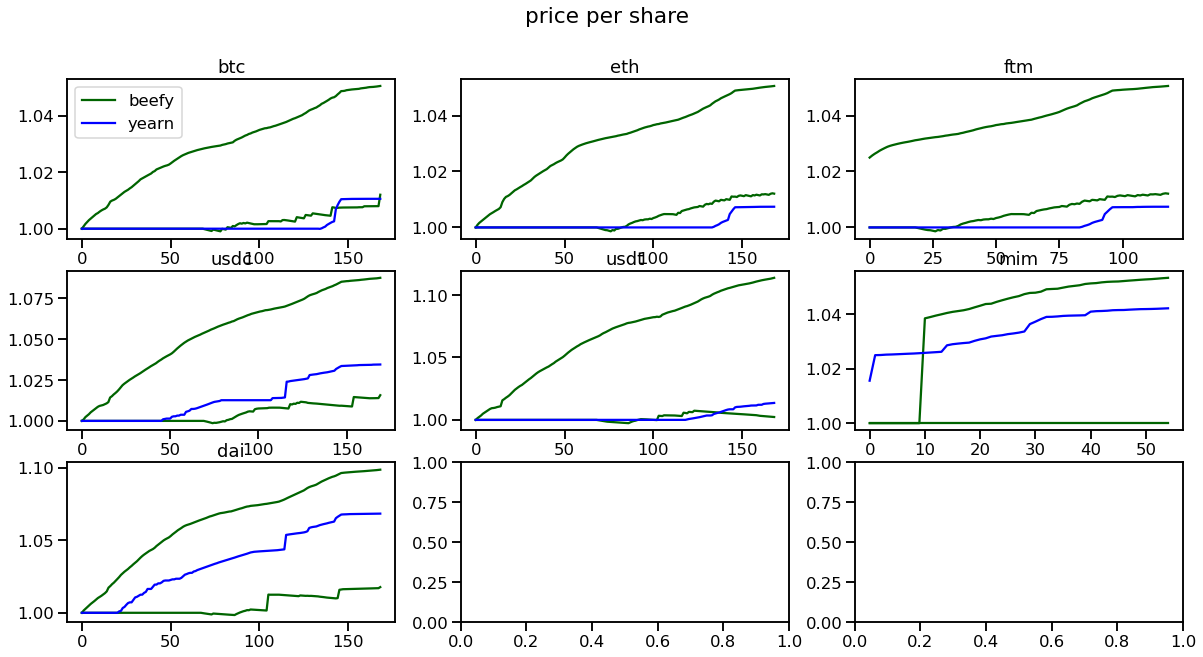

In [237]:

fg,axar = plt.subplots(3,3,figsize=(20,10),sharey=False);axar=axar.reshape(-1)
for aidx,asset_name in enumerate(assetL):
    print(asset_name)
    ## load data
    ypps,bpps1,bpps2 = load_all(asset_name,'pps')
    ## plot
    ax = axar[aidx]
    ax.set_title(asset_name)
    plt_vault_data(ypps,bpps1,bpps2,ax=ax)
    # ax.set_xticks([])
plt.suptitle('price per share')
axar[0].legend()
plt.savefig('figures/pps.png',facecolor='white')

## value locked

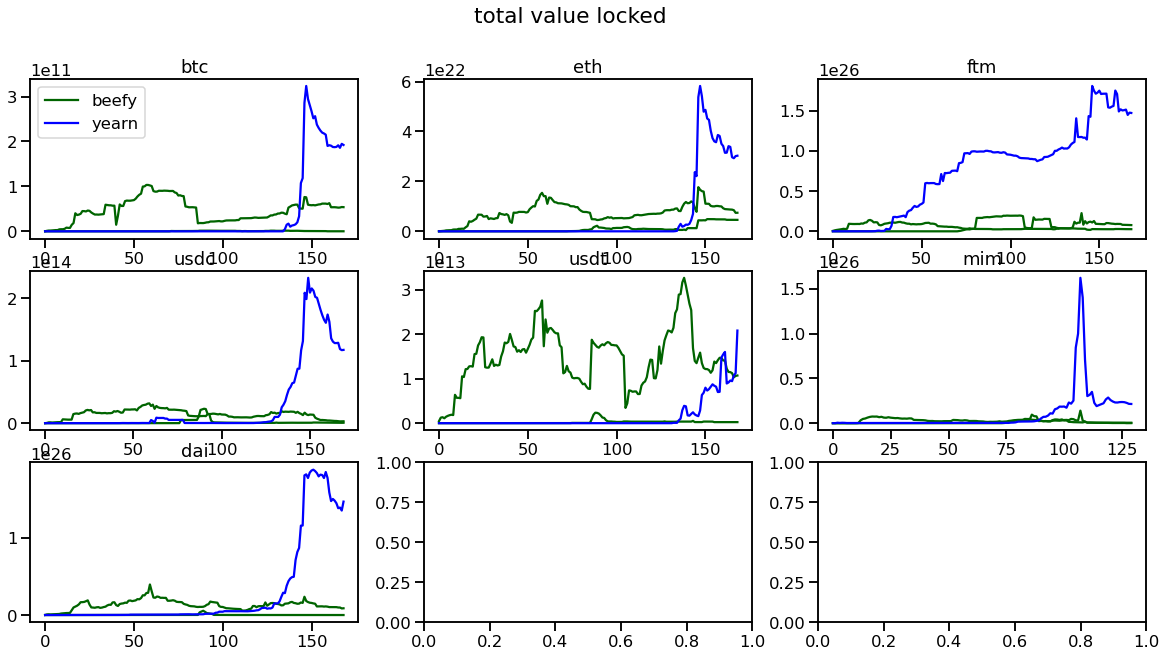

In [234]:
fg,axar = plt.subplots(3,3,figsize=(20,10),sharey=False);axar=axar.reshape(-1)

for aidx,asset_name in enumerate(assetL):
    ## load data
    ytvl,btvl1,btvl2 = load_all(asset_name,dtype='tvl')
    ## plot
    ax = axar[aidx]
    ax.set_title(asset_name)
    plt_vault_data(ytvl,btvl1,btvl2,ax=ax)
    # ax.set_xticks([])
plt.suptitle('total value locked')
axar[0].legend()
plt.savefig('figures/tvl',facecolor='white')

### TVL vs PPS

In [271]:

import itertools

def calc_delta(x,tsteps=2):
        maxsteps = len(x)//tsteps
        x_ = x[-tsteps*maxsteps:].reshape(tsteps,maxsteps)
        x_delta = x_[-1,:] - x_[0,:]
        return x_delta
    
def plt_tvl_vs_pps(asset_name):
    """ """
    ytvl,btvl1,btvl2 = load_all(asset_name,dtype='tvl',preproc_flag=False)
    ypps,bpps1,bpps2 = load_all(asset_name,dtype='pps',preproc_flag=False)

    ytvl_d,btvl1_d,btvl2_d = calc_delta(ytvl),calc_delta(btvl1),calc_delta(btvl2)
    ypps_d,bpps1_d,bpps2_d = calc_delta(ypps),calc_delta(bpps1),calc_delta(bpps2)

    analysisL = [
        [(ytvl_d,ypps_d),(ytvl_d,bpps1_d),(ytvl_d,bpps2_d)], # yearn tvl
        [(btvl1_d,ypps_d),(btvl1_d,bpps1_d),(btvl1_d,bpps2_d)], # bifi1 tvl
        [(btvl2_d,ypps_d),(btvl2_d,bpps1_d),(btvl2_d,bpps2_d)], # bifi2 tvl
    ]

    fg,axar = plt.subplots(3,3,figsize=(20,20),sharey=False)
    
    for ai,(idx,jdx) in enumerate(itertools.product(range(3),range(3))):
        ax=axar[idx,jdx]
        tvl,pps = analysisL[idx][jdx]
        ax.scatter(pps,tvl,c=['r','b'][idx==jdx])
        ax.axhline(0,c='k',lw=.4)
        # ax.set_xscale('log')

    axar[0,0].set_ylabel('$\Delta$ Yearn TVL')
    axar[1,0].set_ylabel('$\Delta$ Beefy-1 TVL')
    axar[2,0].set_ylabel('$\Delta$ Beefy-2 TVL')
    axar[2,0].set_xlabel('$\Delta$ Yearn PPS')
    axar[2,1].set_xlabel('$\Delta$ Beefy-1 PPS')
    axar[2,2].set_xlabel('$\Delta$ Beefy-2 PPS')
    plt.suptitle(asset_name)
    plt.savefig('figures/tvl_vs_pps/%s.png'%asset_name,facecolor='white')
    
for asset_name in assetL:
    print(asset_name)
    plt_tvl_vs_pps(asset_name)
    plt.close('all')

btc
eth
ftm
usdc
usdt
mim
dai


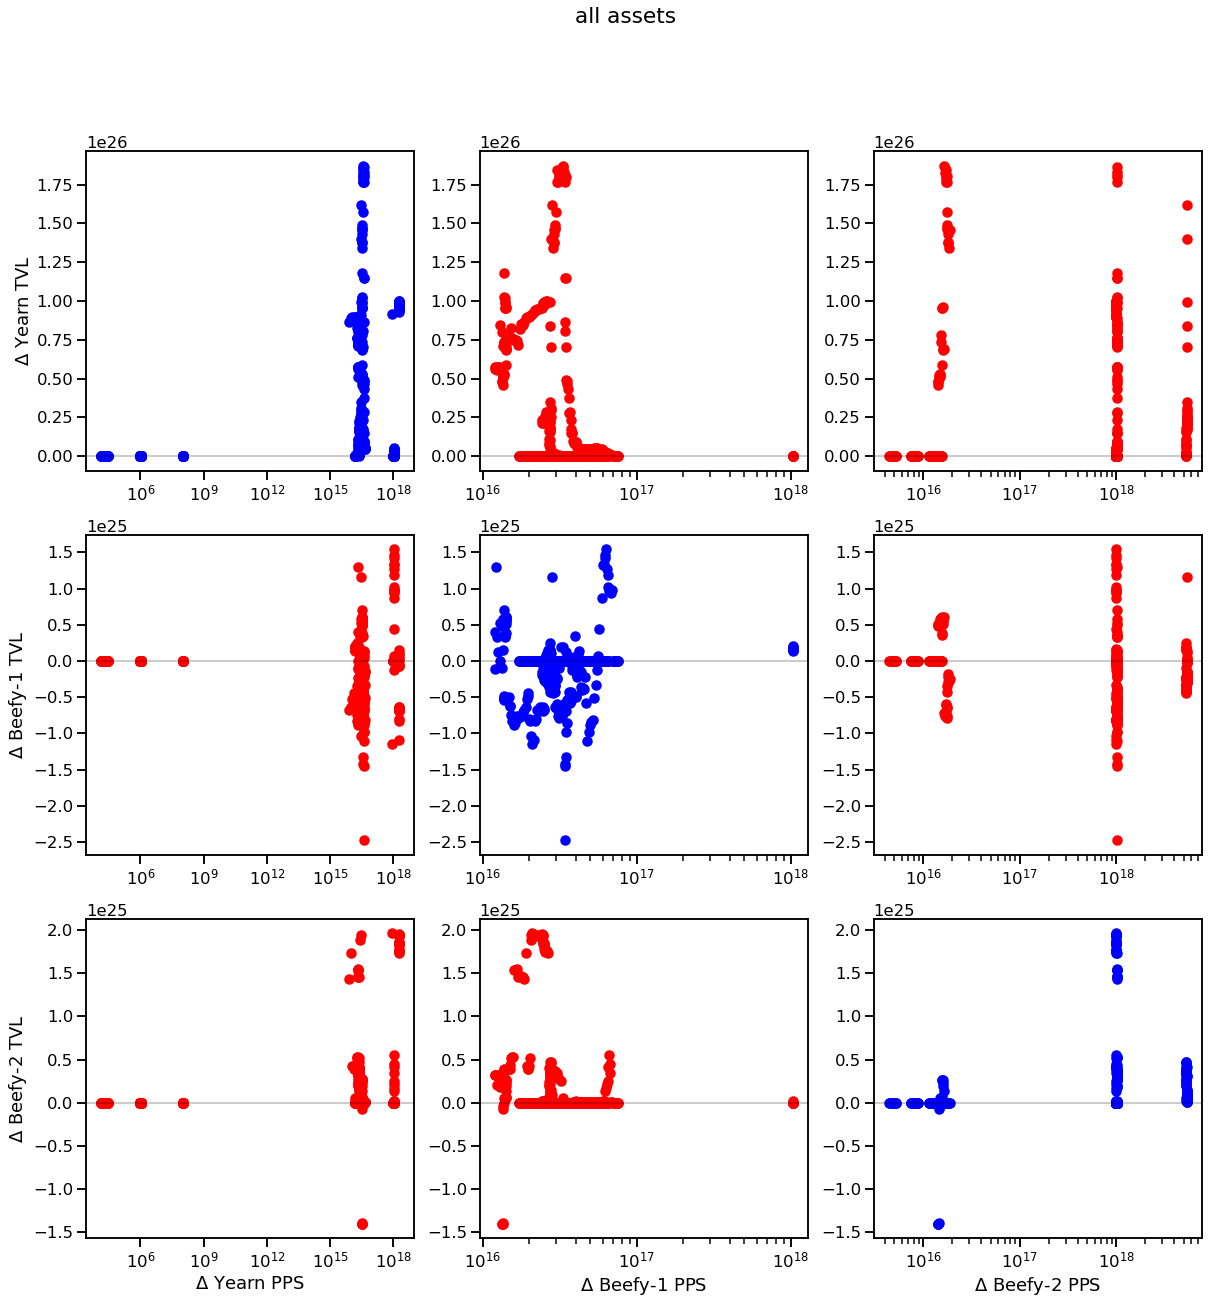

In [ ]:
ytvl_del_all = np.concatenate(
    [calc_delta(load_all(asset_name,dtype='tvl',preproc_flag=False)[0]
               ) for asset_name in assetL]
)
btvl1_del_all = np.concatenate(
    [calc_delta(load_all(asset_name,dtype='tvl',preproc_flag=False)[1]
               ) for asset_name in assetL]
)
btvl2_del_all = np.concatenate(
    [calc_delta(load_all(asset_name,dtype='tvl',preproc_flag=False)[2]
               ) for asset_name in assetL]
)
ypps_del_all = np.concatenate(
    [calc_delta(load_all(asset_name,dtype='pps',preproc_flag=False)[0]
               ) for asset_name in assetL]
)
bpps1_del_all = np.concatenate(
    [calc_delta(load_all(asset_name,dtype='pps',preproc_flag=False)[1]
               ) for asset_name in assetL]
)
bpps2_del_all = np.concatenate(
    [calc_delta(load_all(asset_name,dtype='pps',preproc_flag=False)[2]
               ) for asset_name in assetL]
)

analysisL = [
    [(ytvl_del_all,ypps_del_all),(ytvl_del_all,bpps1_del_all),(ytvl_del_all,bpps2_del_all)], # yearn tvl
    [(btvl1_del_all,ypps_del_all),(btvl1_del_all,bpps1_del_all),(btvl1_del_all,bpps2_del_all)], # bifi1 tvl
    [(btvl2_del_all,ypps_del_all),(btvl2_del_all,bpps1_del_all),(btvl2_del_all,bpps2_del_all)], # bifi2 tvl
]

fg,axar = plt.subplots(3,3,figsize=(20,20),sharey=False)

for ai,(idx,jdx) in enumerate(itertools.product(range(3),range(3))):
    ax=axar[idx,jdx]
    tvl,pps = analysisL[idx][jdx]
    ax.scatter(pps,tvl,c=['r','b'][idx==jdx])
    ax.axhline(0,c='k',lw=.4)
    ax.set_xscale('log')

axar[0,0].set_ylabel('$\Delta$ Yearn TVL')
axar[1,0].set_ylabel('$\Delta$ Beefy-1 TVL')
axar[2,0].set_ylabel('$\Delta$ Beefy-2 TVL')
axar[2,0].set_xlabel('$\Delta$ Yearn PPS')
axar[2,1].set_xlabel('$\Delta$ Beefy-1 PPS')
axar[2,2].set_xlabel('$\Delta$ Beefy-2 PPS')
plt.suptitle('all assets')
plt.savefig('figures/tvl_vs_pps/agg.png',facecolor='white')

# analysis of single protocol data

# beefy

https://ftmscan.com/address/0x49c68eDb7aeBd968F197121453e41b8704AcdE0C#readContract


In [3]:
len(beefyVaults.keys()),beefyVaults.keys()

(21,
 dict_keys(['bifi', 'btc1', 'btc2', 'eth1', 'eth2', 'ftm1', 'ftm2', 'usdc1', 'usdc2', 'usdt1', 'usdt2', 'mim1', 'mim2', 'dai1', 'dai2', 'boo1', 'frax1', 'crv1', 'crv2', 'spell1', 'dola1']))

## TVL

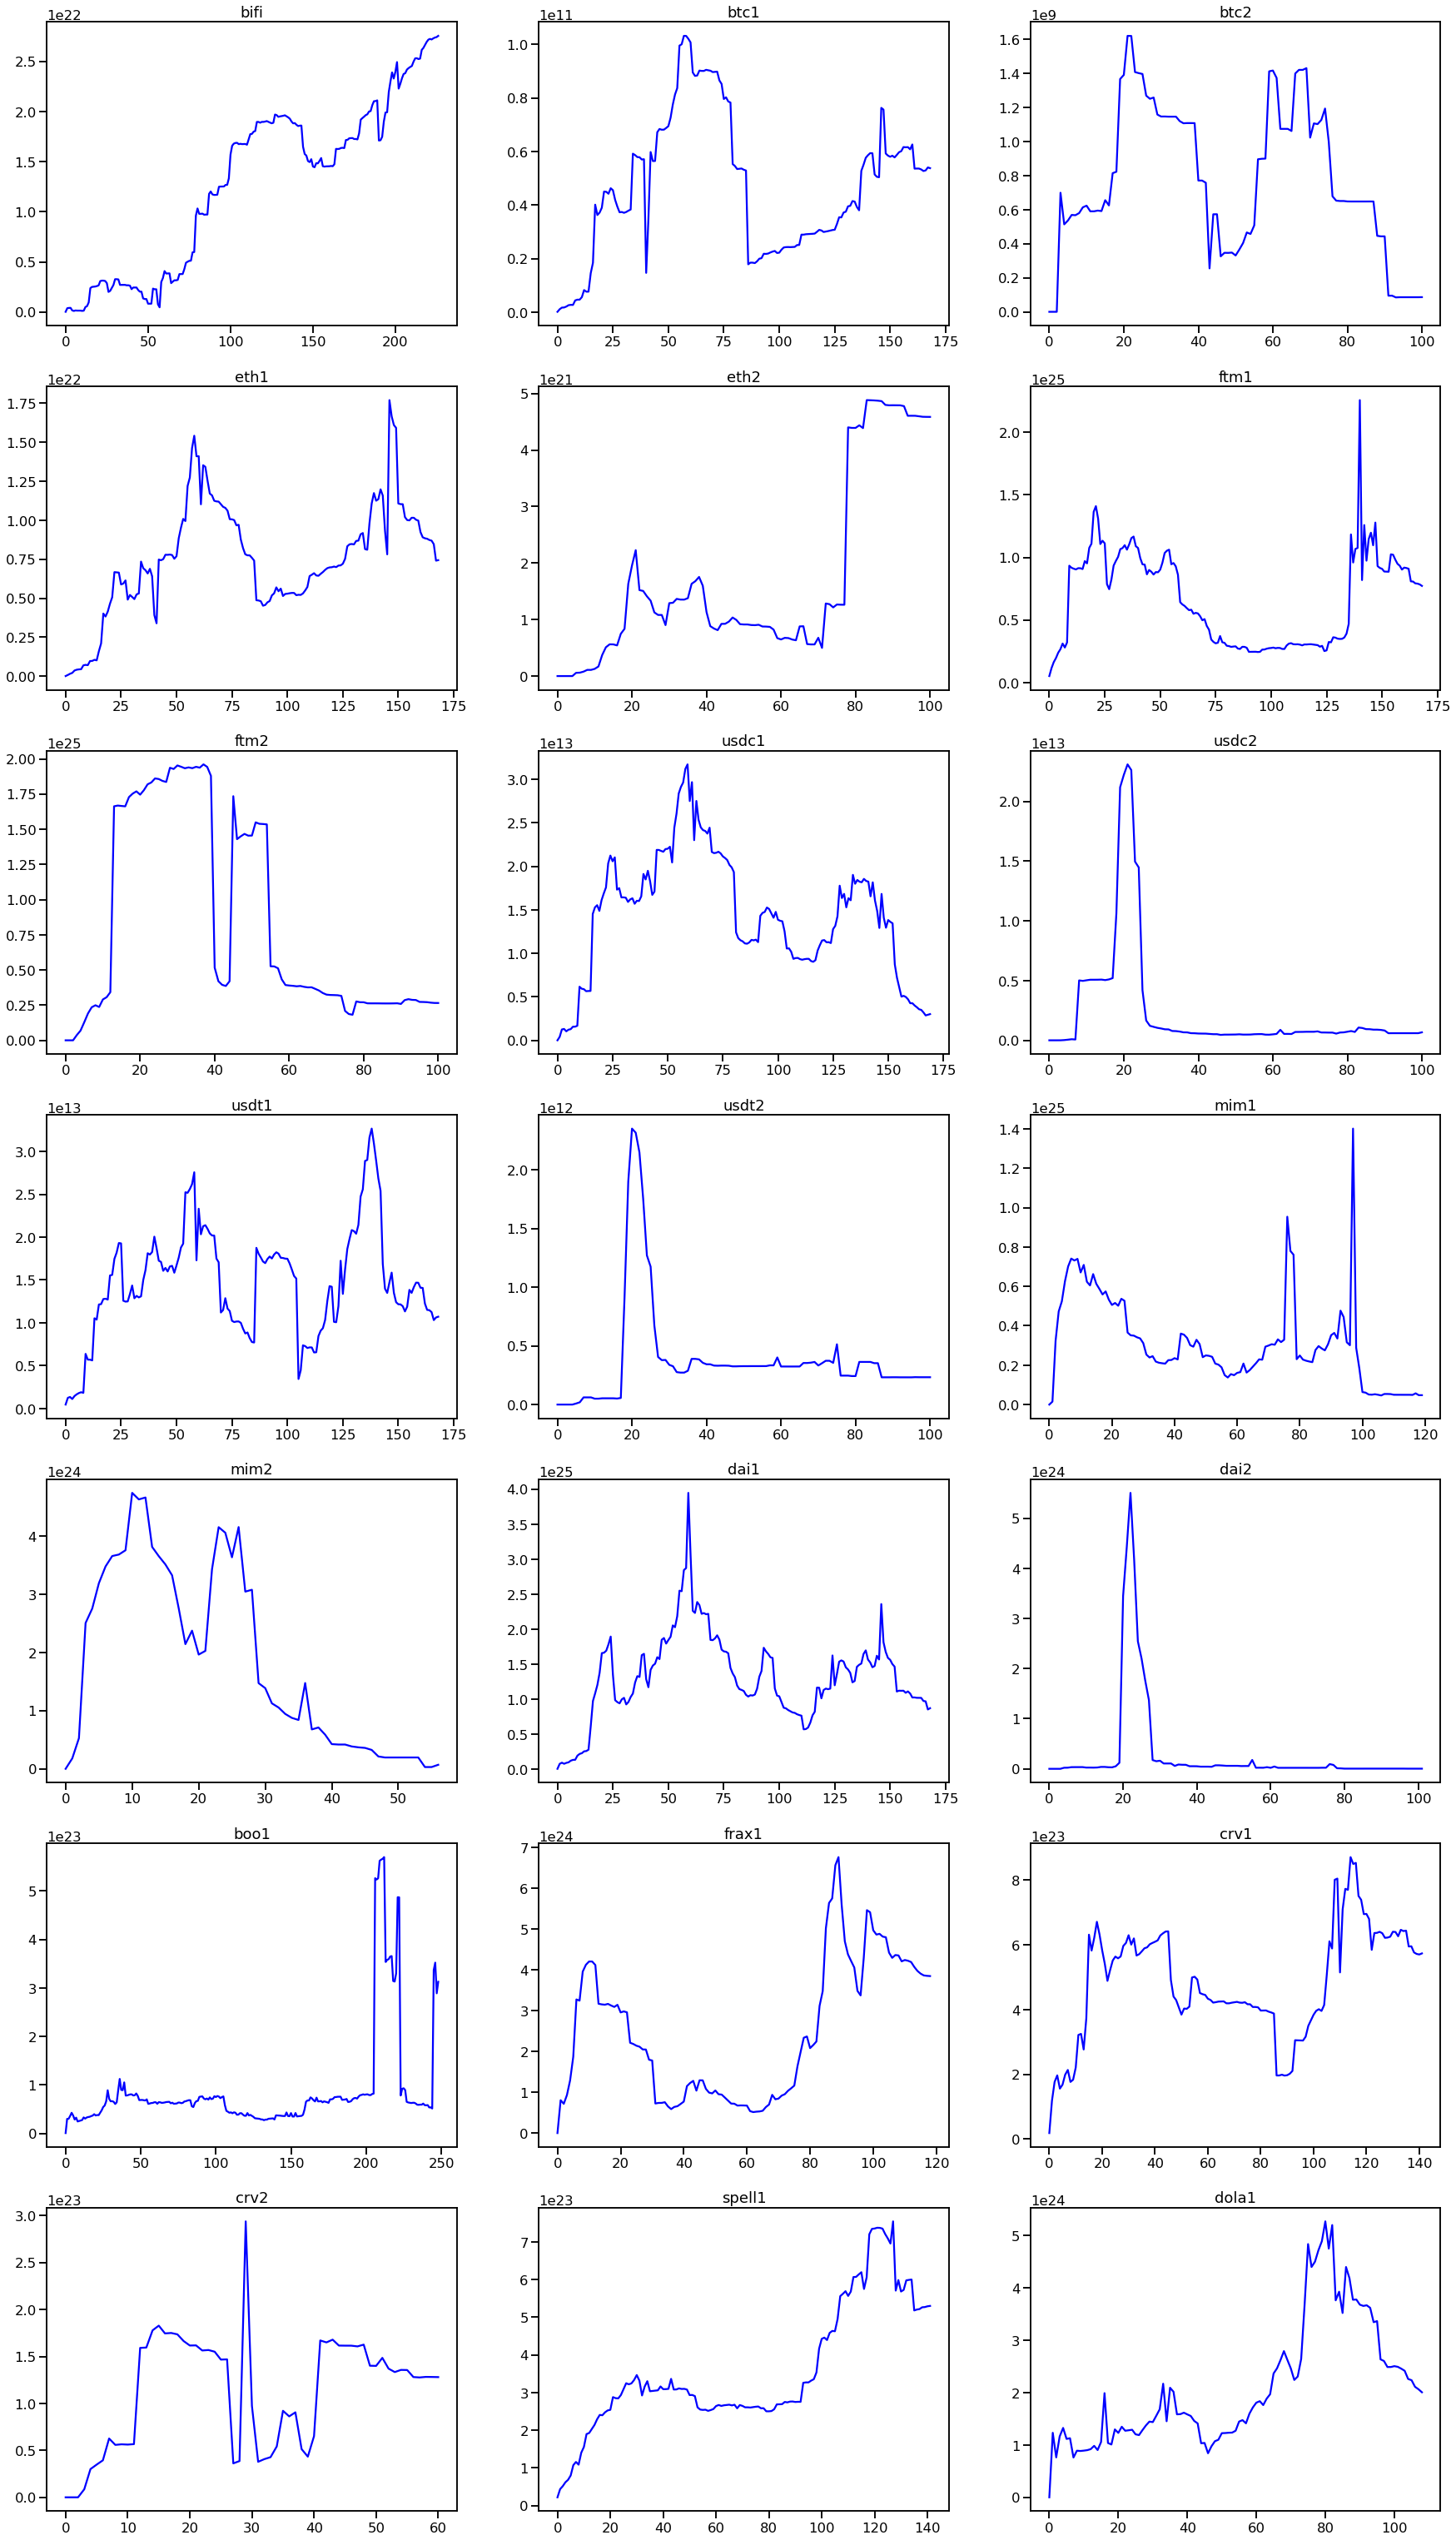

In [215]:
f,axar = plt.subplots(7,3,figsize=(30,55)); axar=axar.reshape(-1)
for aidx,asset_name in enumerate(beefyVaults.keys()):
    ax = axar[aidx]
    tvl,pps = load_data('beefy',asset_name).values()
    ax.plot(tvl,c='b',label='bal')
    # ax.plot(supply,c='darkgreen',label='supply')
    ax.set_title(asset_name)
plt.savefig('figures/beefy-tvl')

## PPS

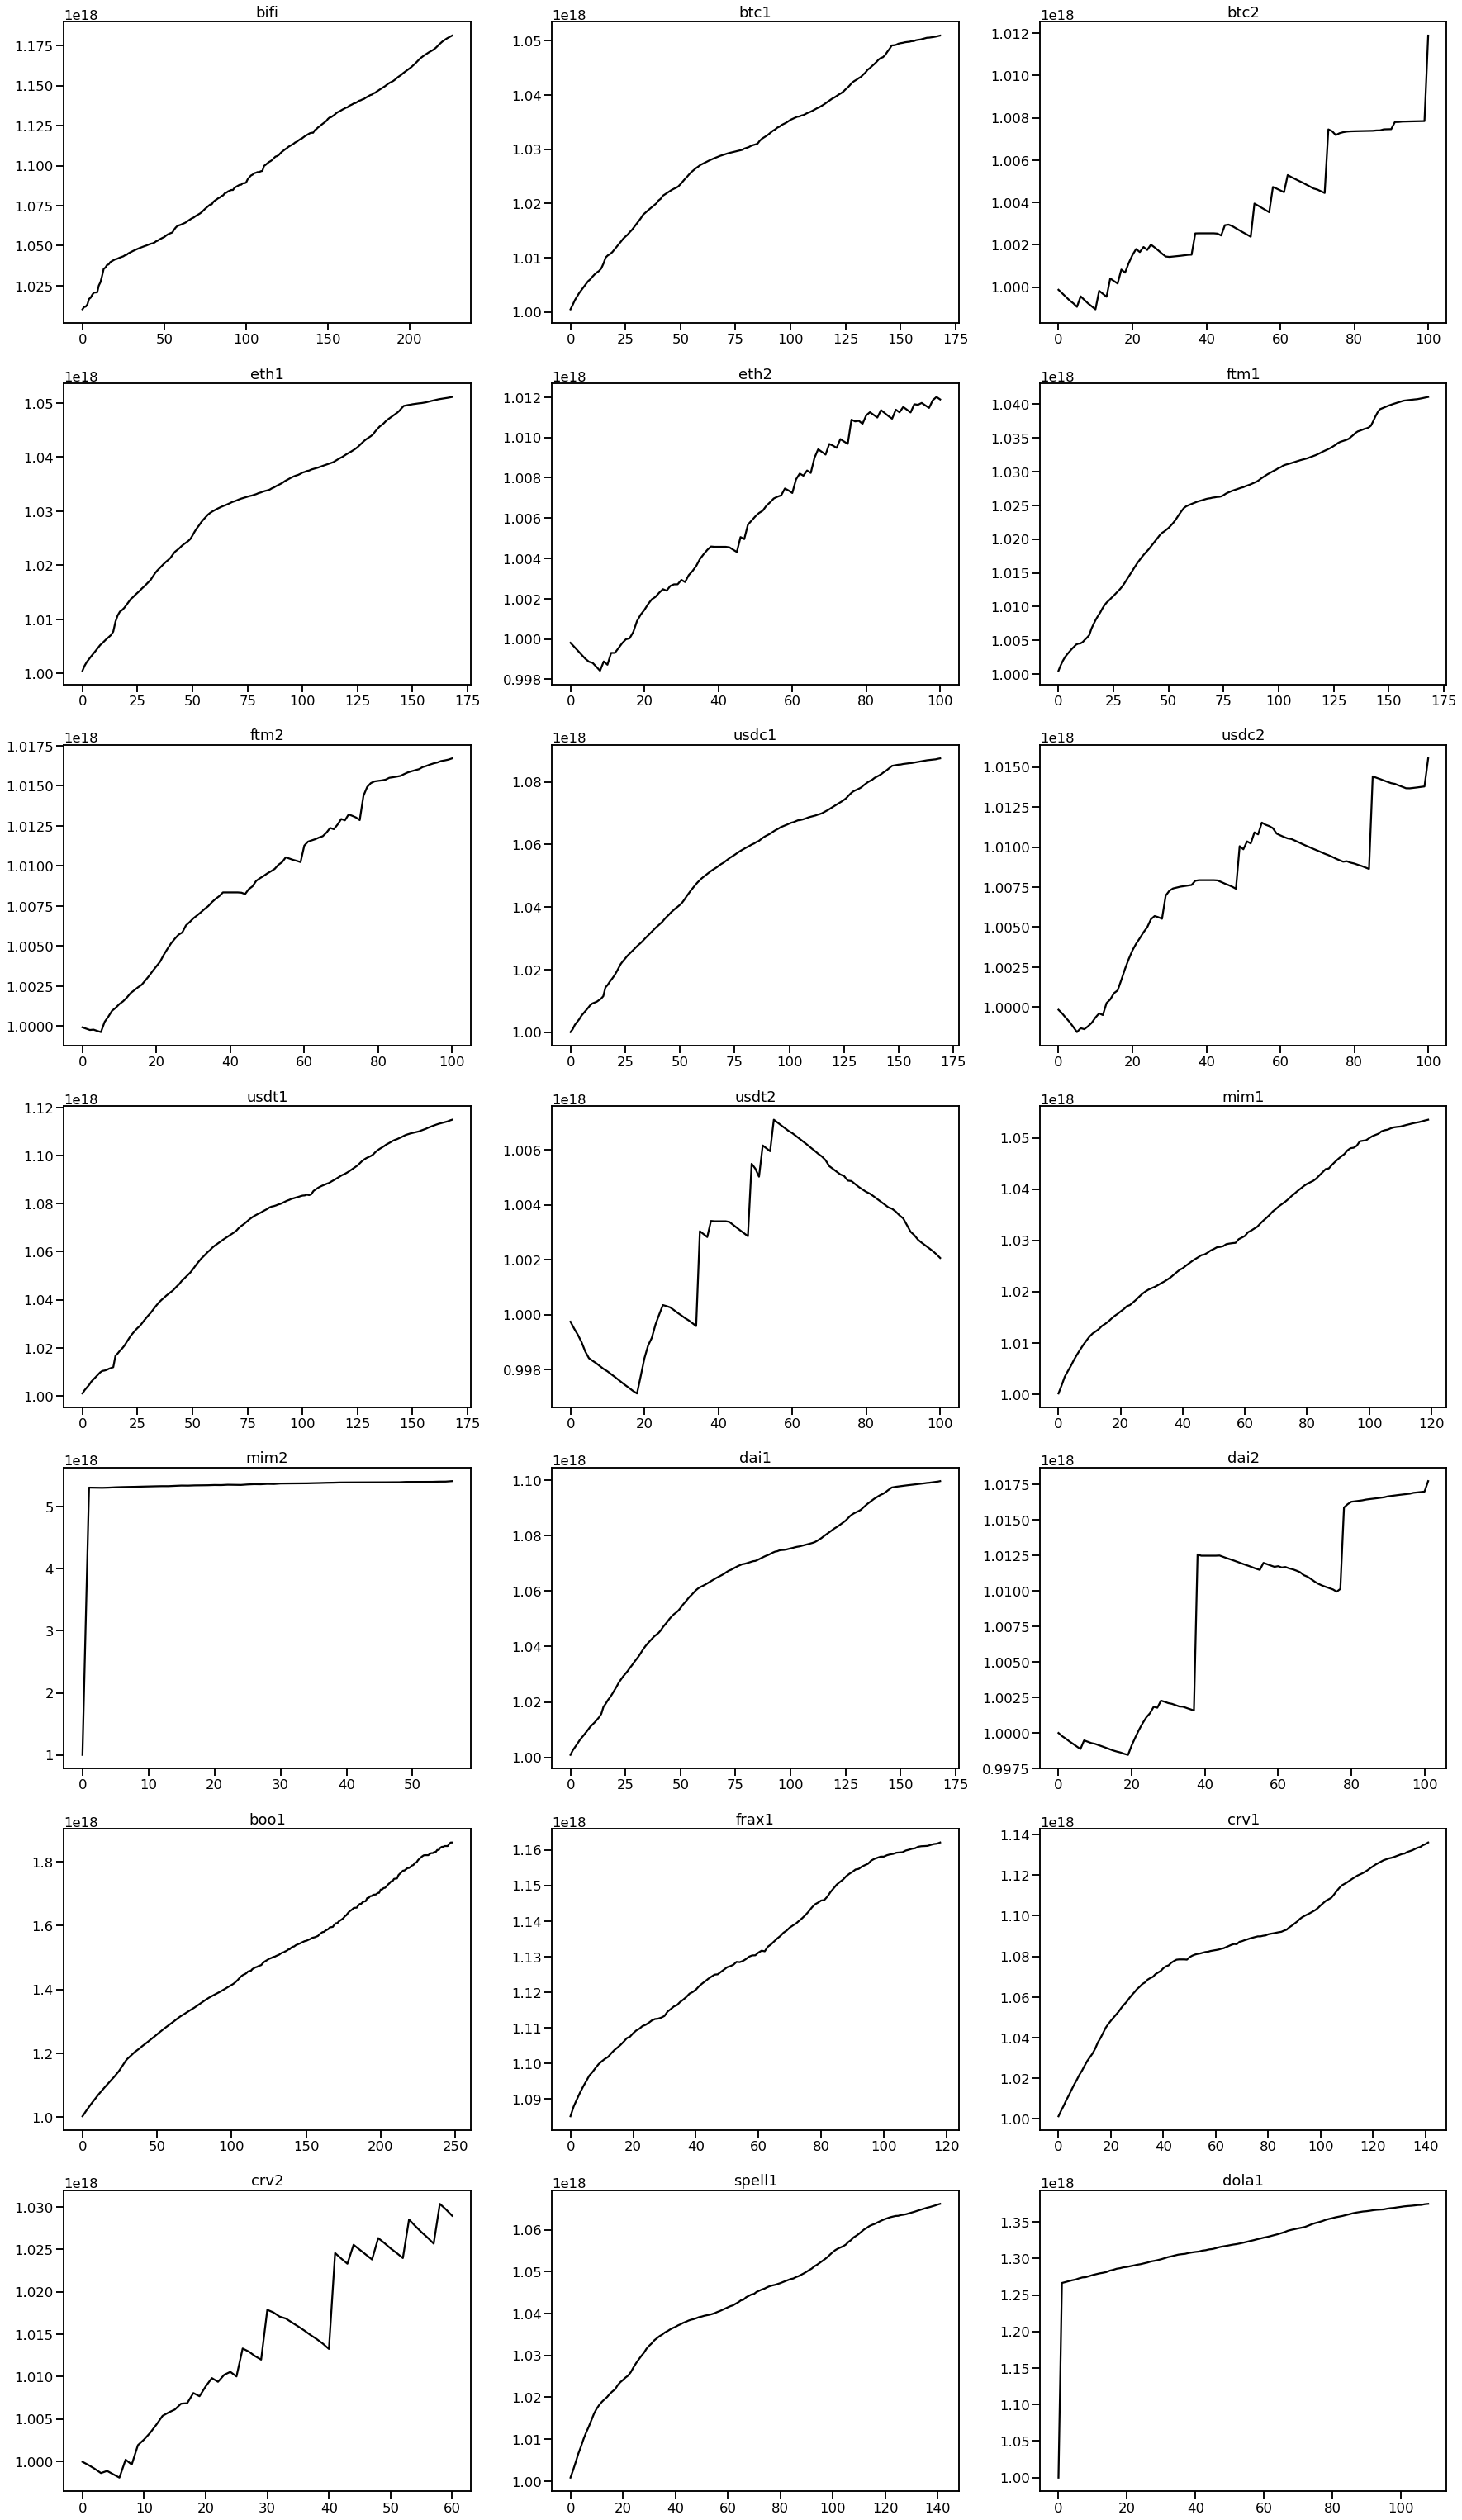

In [235]:
f,axar = plt.subplots(7,3,figsize=(30,55)); axar=axar.reshape(-1)
for aidx,asset_name in enumerate(beefyVaults.keys()):
    ax = axar[aidx]
    tvl,pps = load_data('beefy',asset_name).values()
    ax.plot(pps,c='k',label='pps')
    ax.set_title(asset_name)
# plt.savefig('figures/beefy-pps')

# Yearn

# TVL

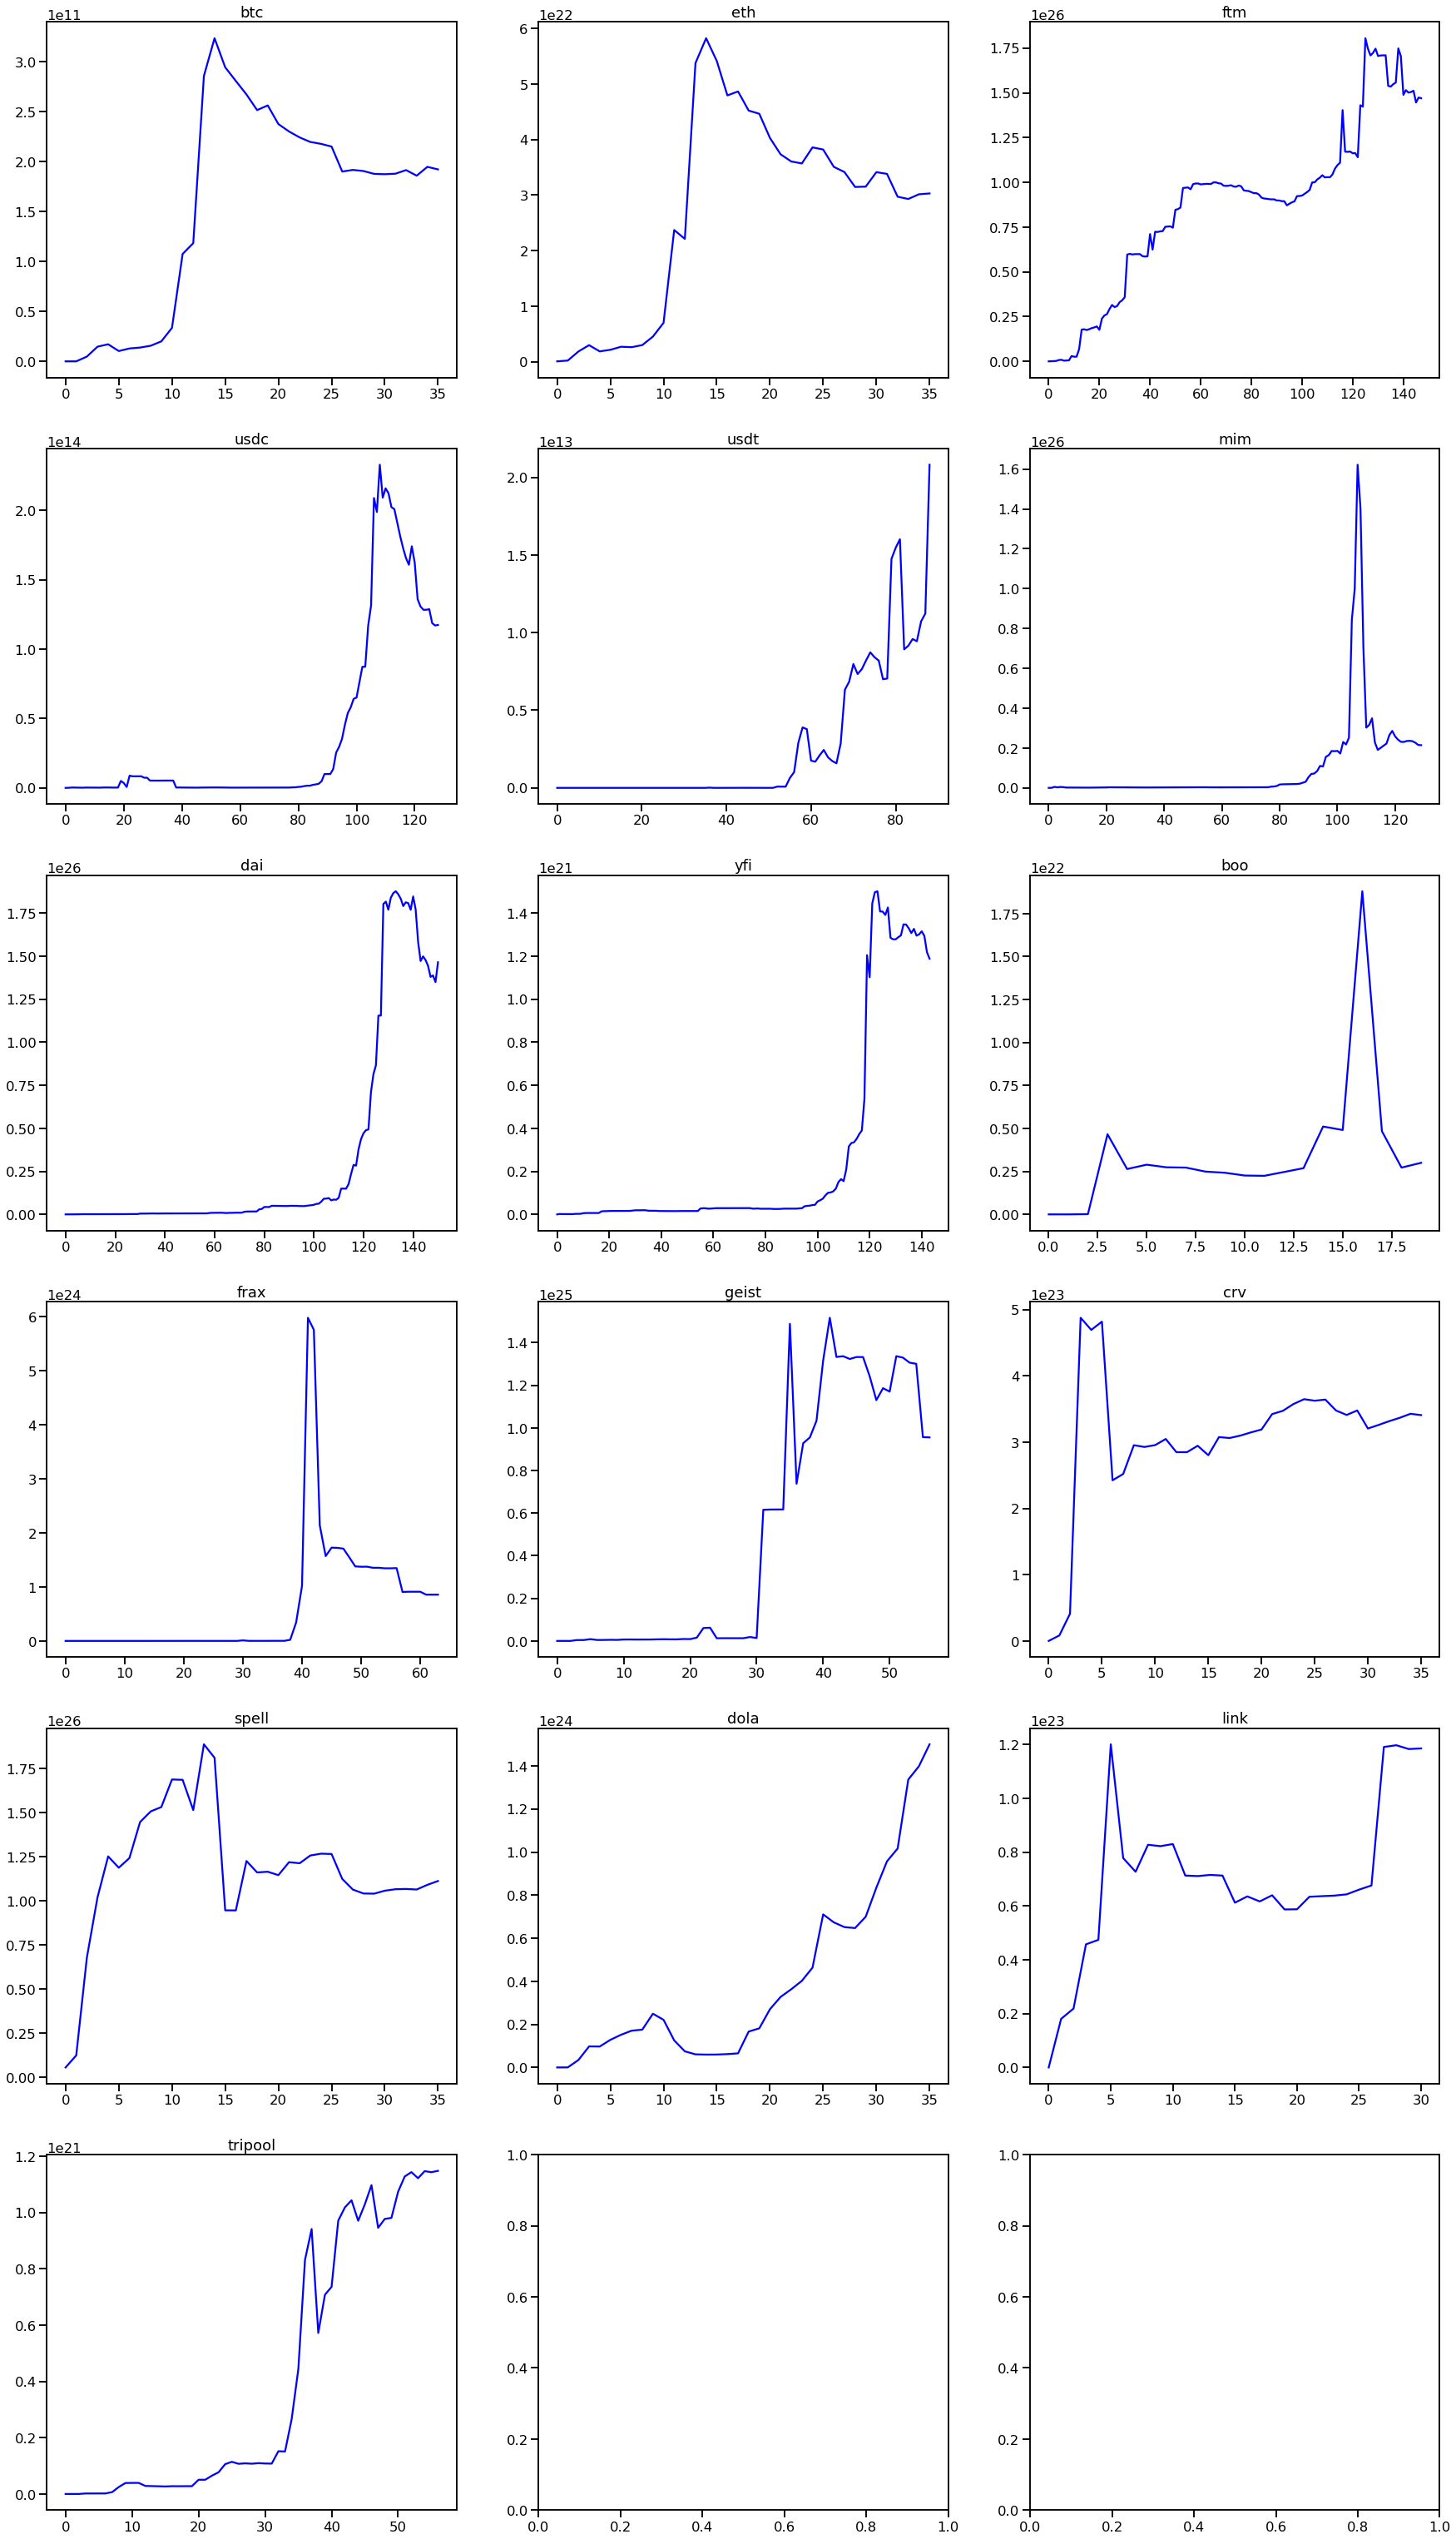

In [216]:
f,axar = plt.subplots(6,3,figsize=(30,55)); axar=axar.reshape(-1)
for aidx,asset_name in enumerate(yearnVaults.keys()):
    ax = axar[aidx]
    tvl,pps = load_data('yearn',asset_name).values()
    ax.plot(tvl,c='b',label='assets')
    # ax.plot(supply,c='darkgreen',label='supply')
    # ax.plot(debt,c='r',label='debt')
    ax.set_title(asset_name)
plt.savefig('figures/yearn-tvl')

## PPS

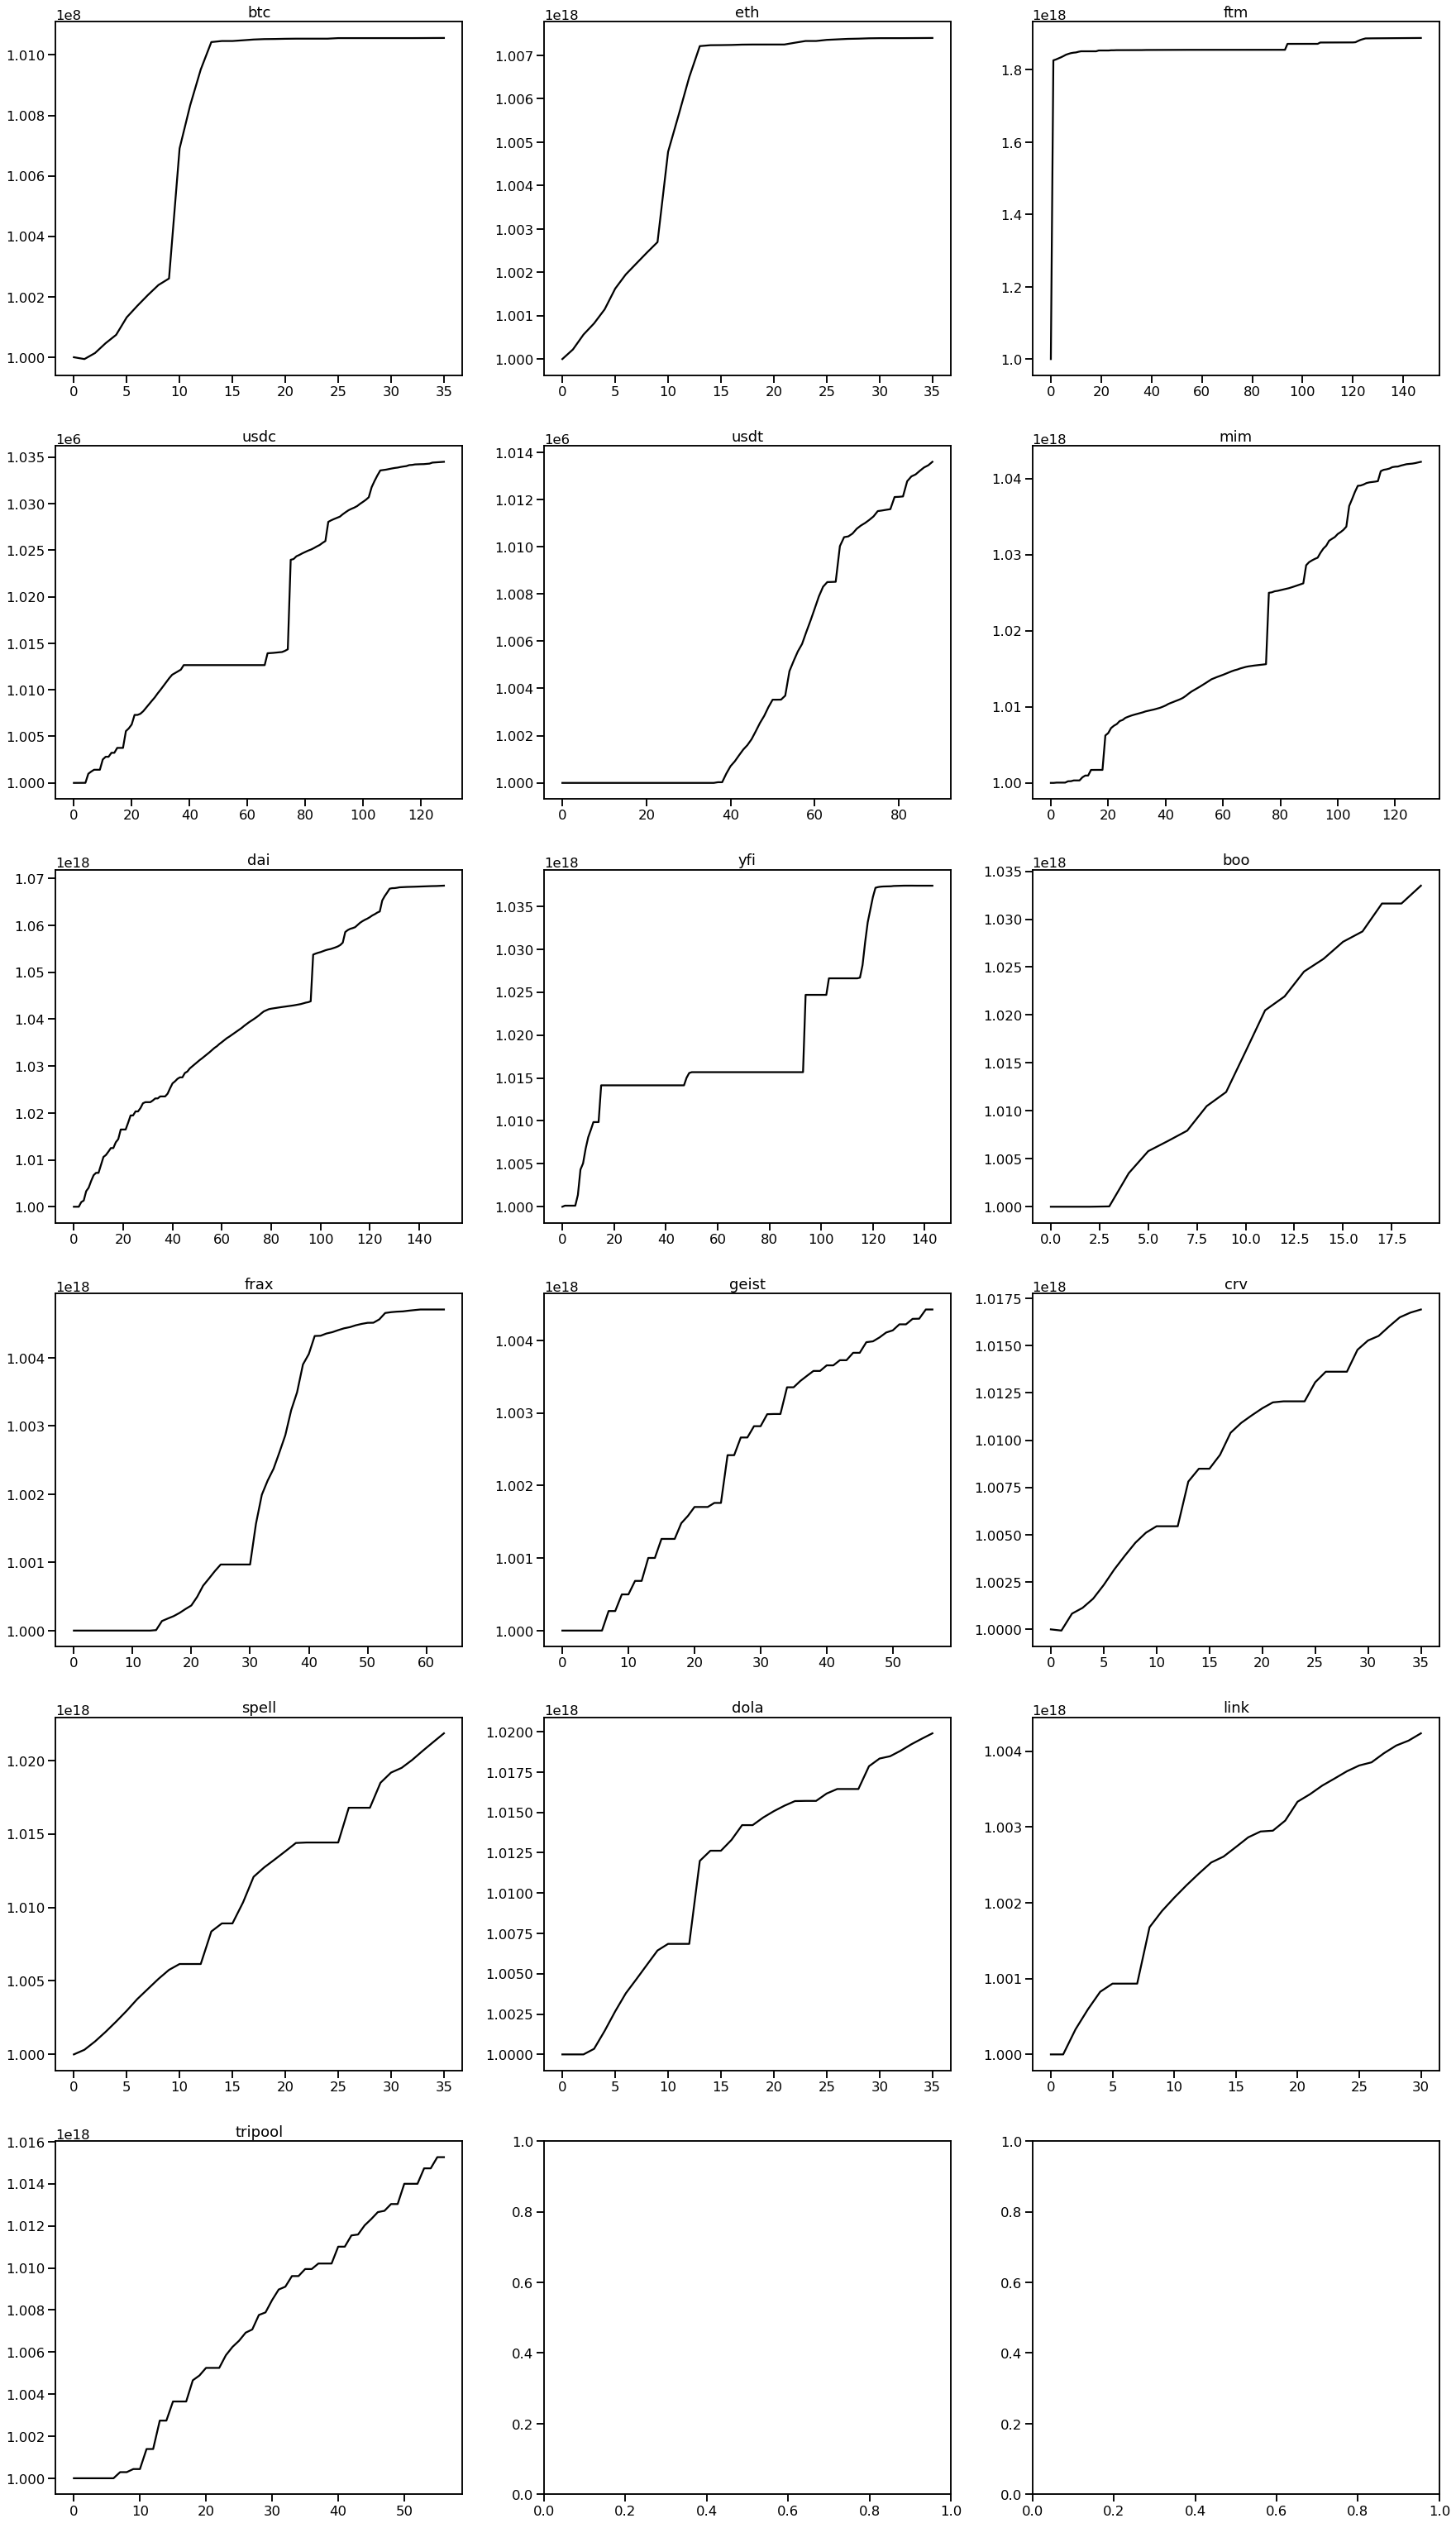

In [217]:
f,axar = plt.subplots(6,3,figsize=(30,55)); axar=axar.reshape(-1)
for aidx,asset_name in enumerate(yearnVaults.keys()):
    ax = axar[aidx]
    tvl,pps = load_data('yearn',asset_name).values()
    ax.plot(pps,c='k',label='pps')
    ax.set_title(asset_name)
    
# plt.savefig('figures/yearn-pps')

# writeup figs

In [210]:
fg,axar = plt.subplots(3,3,figsize=(5,5));axar.reshape=
for asset_name in assetL:
    tvl,pps = load_data('beefy',asset_name).items()


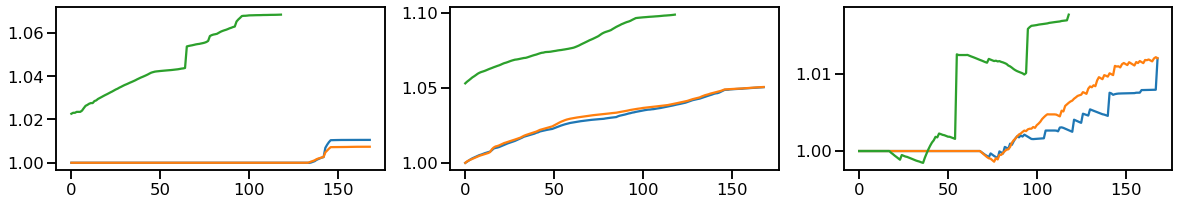

In [201]:
f,axar = plt.subplots(1,3,figsize=(20,3))

for asset_name in ['btc','eth','ftm']:
    yd,bd1,bd2 = load_all(asset_name,dtype='pps',preproc=True)
    axar[0].plot(yd)
    axar[1].plot(bd1)
    axar[2].plot(bd2)